# Group 33 Project: Prediction of Diabetes Diagnosis #

Group members: Billie Beis-Leech, Anna Daoust, Fintan Casey, and Yash Mali

# Introduction

Diabetes is a health condition that affects how our bodies process nutrients into energy. Characterized by a deficiency of insulin, diabetes results in an abnormally high amount of glucose in the bloodstream. This can cause serious health problems, and so it is beneficial to predict in early stages.

Our study will answer the following predictive question: What is the diabetes status of a patient, given their medical profile? The Diabetes Prediction Dataset will be used to answer this question, containing medical and demographical data such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. Diabetes status is labeled with a 1 indicating the presence of diabetes, and a 0 indicating the absence. These findings can be used to analyze the functionality of these predictors, further developing our predictive models for diabetes status.

# Methods

From the Diabetes Prediction Dataset, the numerical predictors chosen for this study are age, BMI, HbA1c level, and blood glucose level. Both HbA1c levels and blood glucose levels are standard for predicting diabetes in patients, and higher levels are commonly used to diagnose and initiate treatment. Age is a crucial predictor because older age increases susceptibility to numerous health concerns, including diabetes. Therefore, age will be constricted to 18 years of age and older. Diabetes generally increases body mass, as the body needs to consume more nutrients to get glucose into cells when insulin is not properly functioning. As such, BMI is an ideal predictor and will be compared to the other predictors in data visualizations. Gender, hypertension, heart disease, and smoking history were not chosen as predictors in this study, as these variables are categorical and would not be as useful in formulating a knn classification model. 


To visualize the data, scatter plots will be presented as 2500 randomly generated data points to prevent overplotting. BMI is plotted with each predictor, creating a total of three plots. The data points will be colored in accordance with the diabetes diagnosis, either 'Not Diabetic' or 'Diabetic'. These predictors will then be used to train a classification model. The accuracy of this model will be computed to assess the functionality of the specified predictors of diabetes.

## Reading and wrangling the data

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [15]:
# setting the seed
set.seed(1)

# loading the data
url <- "https://raw.githubusercontent.com/billiehbl/project_group33/main/diabetes_prediction_dataset.csv"
diabetes_data <- read_csv(url)

# tidying the data
tidy_diabetes <- diabetes_data |> filter(smoking_history != "No Info") |> filter(gender != 'Other')|>
    filter(age >= 2)|> mutate(diabetes = as_factor(diabetes))

# creating a sample of the data
tidy_diabetes_sample <- tidy_diabetes |>
    sample_n(10000)
head(tidy_diabetes_sample)

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
Female,35,0,0,never,22.24,5.8,159,0
Female,67,0,0,never,16.96,6.1,85,0
Male,58,0,1,former,28.92,6.0,100,0
Female,50,0,0,not current,25.32,6.1,200,0
Female,24,0,0,never,27.32,6.6,145,0
Male,40,0,0,not current,27.32,6.6,90,0


## Splitting into testing and training data sets

In [17]:
# creating the training / testing split
diabetes_split <- initial_split(tidy_diabetes_sample, prop = 0.75, strata = diabetes)
diabetes_train <- training(diabetes_split)
diabetes_train = diabetes_train[sample(1:nrow(diabetes_train)), ] # shuffles data frame
diabetes_test <- testing(diabetes_split)

## Summary statistics

*Calculating the number of observations in each category*

In [18]:
training_counts <- diabetes_train |>
    group_by(diabetes) |>
    summarize(count = n())
training_counts

diabetes,count
<fct>,<int>
0,6657
1,843


*Calculating summary statistics for predictor variables*

In [19]:
# calculating means for each predictor variable
means <- diabetes_train |>
        summarize(age = mean(age), bmi = mean(bmi),
        HbA1c = mean(HbA1c_level), blood_glucose = mean(blood_glucose_level))
tidy_means <- pivot_longer(means, cols = age:blood_glucose,
        names_to = "factor", values_to = "mean")

# calculating minimum values for each predictor variable
mins <- diabetes_train |>
        summarize(age = min(age), bmi = min(bmi),
        HbA1c = min(HbA1c_level), blood_glucose = min(blood_glucose_level))
tidy_mins <- pivot_longer(mins, cols = age:blood_glucose,
        names_to = "factor", values_to = "minimum")

# calculating maximum values for each predictor variable
maximum <- diabetes_train |>
        summarize(age = max(age), bmi = max(bmi),
        HbA1c = max(HbA1c_level), blood_glucose = max(blood_glucose_level))
tidy_max <- pivot_longer(maximum, cols = age:blood_glucose,
        names_to = "factor", values_to = "maximum")

# creating final summary table
summary <- tidy_means |>
        bind_cols(tidy_mins |> select(minimum)) |>
        bind_cols(tidy_max |> select(maximum))
summary

factor,mean,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>
age,46.566133,2.00,80.00
bmi,28.578629,11.44,88.76
HbA1c,5.572187,3.50,9.00
blood_glucose,140.025733,80.00,300.00


## Exploratory visualizations

*Creating a smaller sample from the data*

In [21]:
diabetes_sample <- diabetes_train |>
    sample_n(2500)

*Making the visualizations*

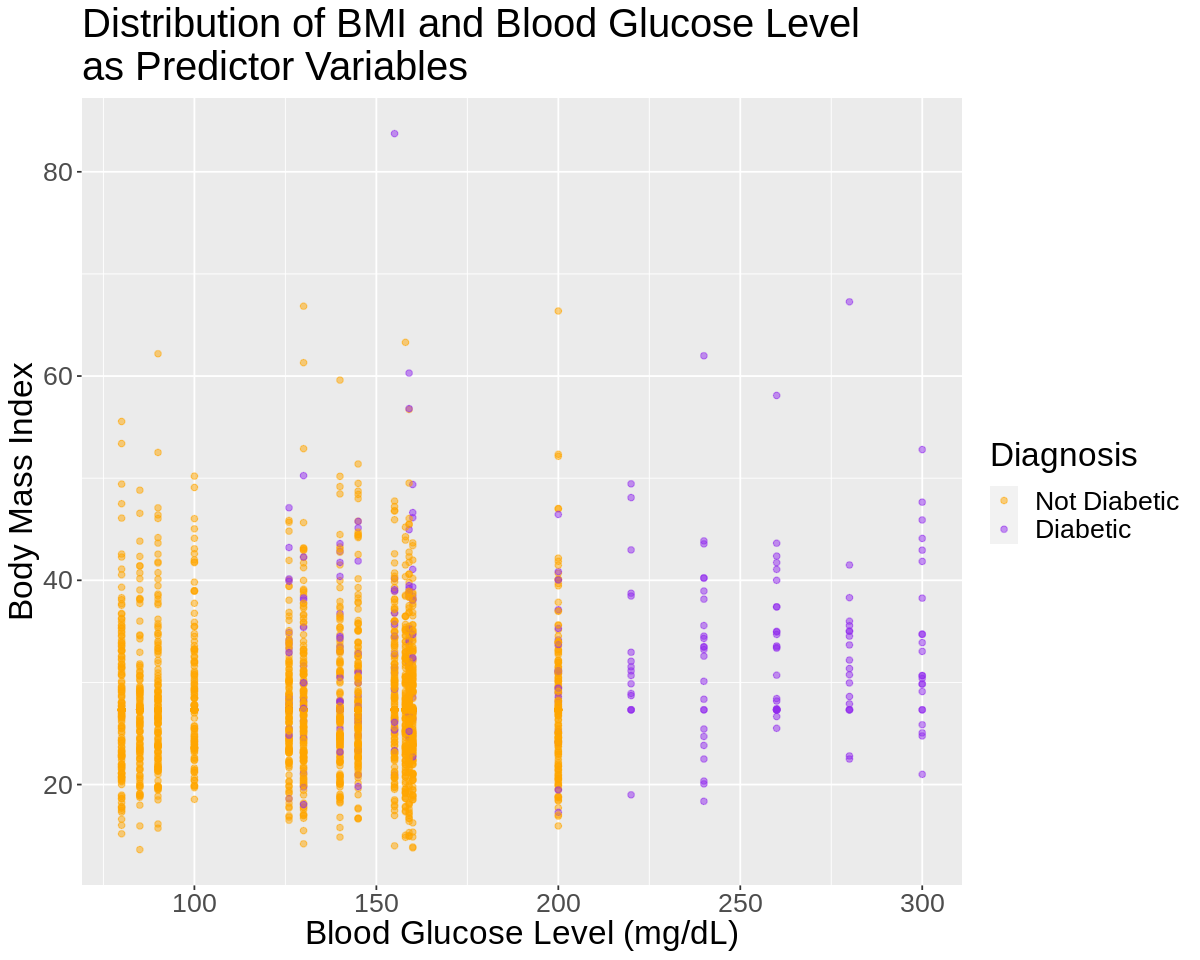

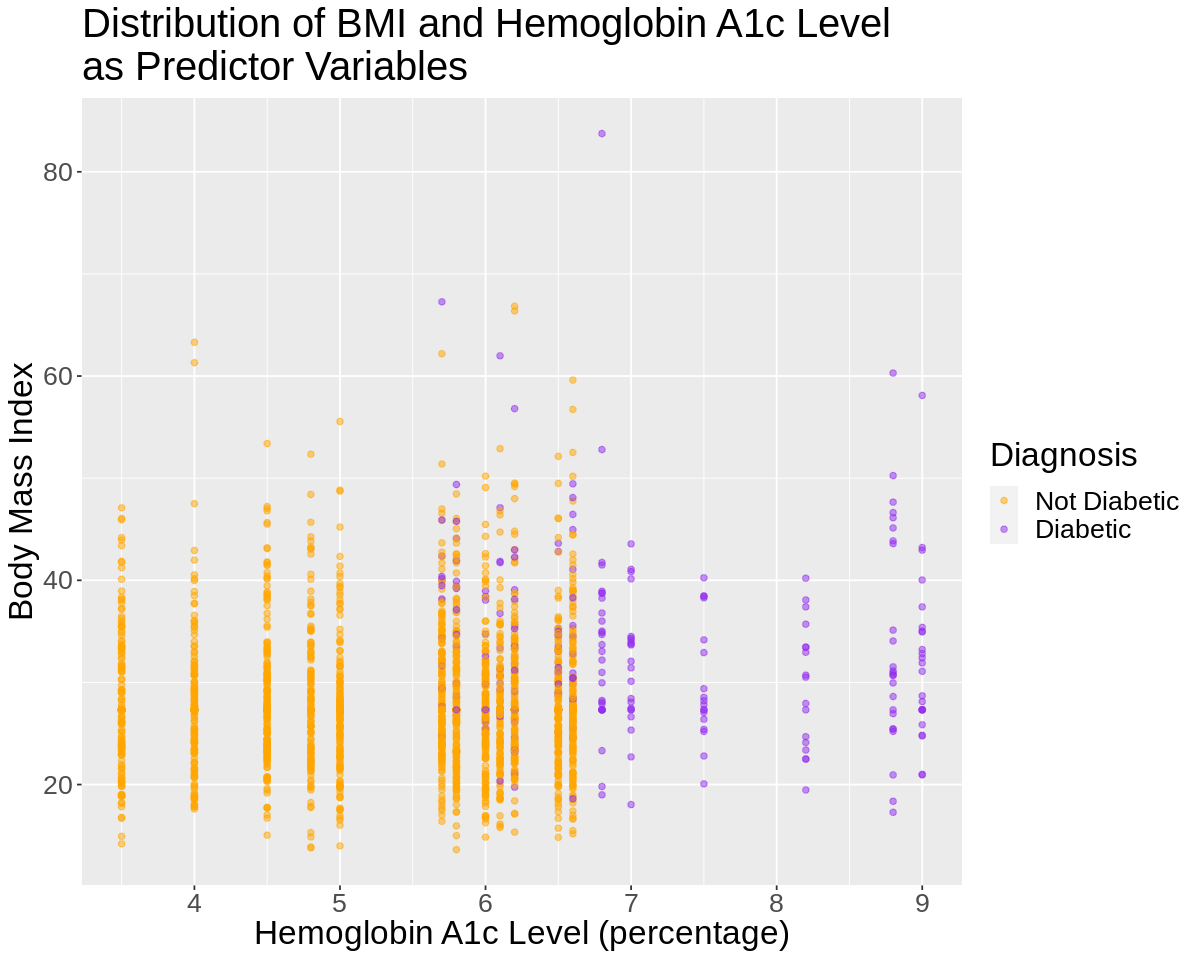

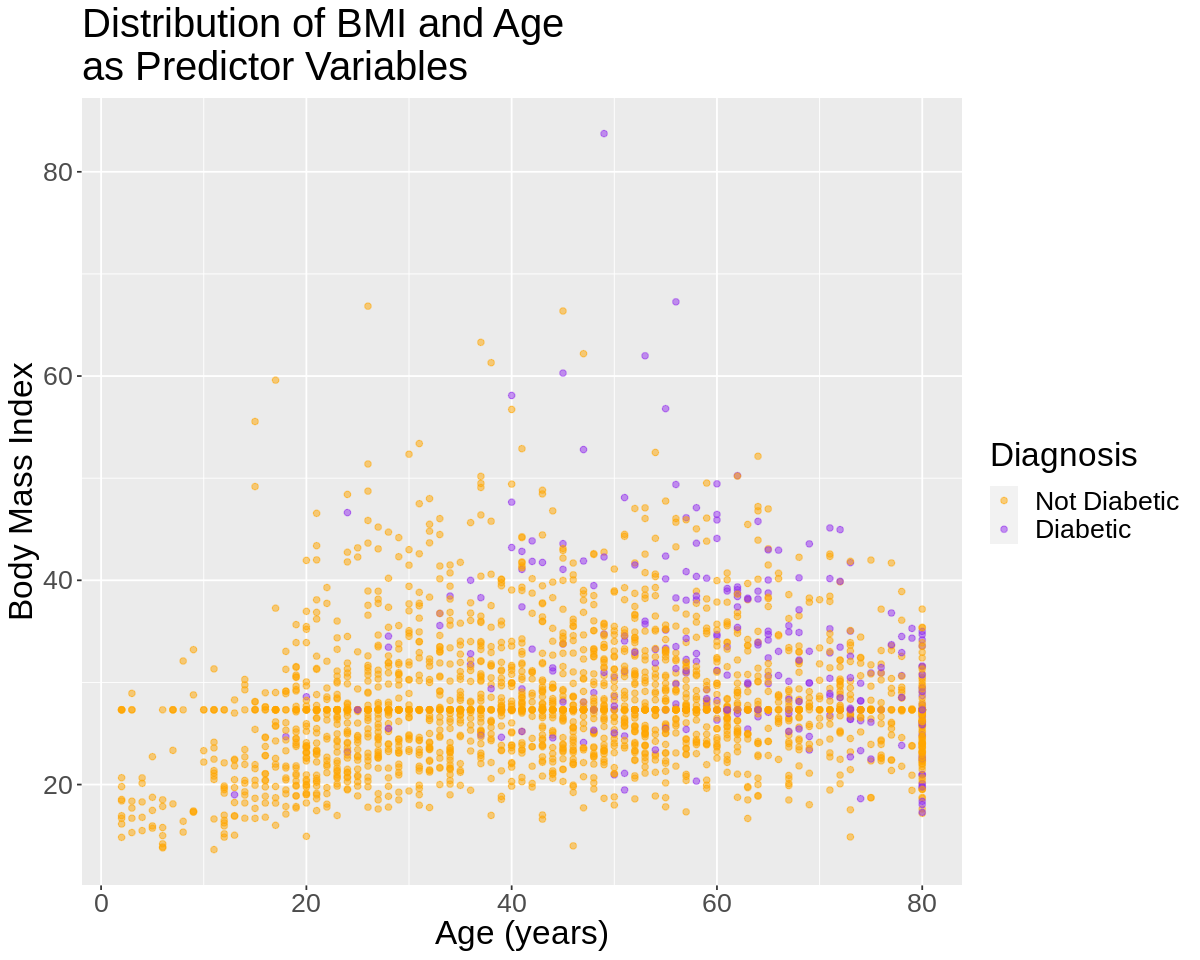

In [22]:
options(repr.plot.width = 10, repr.plot.height = 8)

# creating graph of the distribution of BMI and blood glucose predictors
bmi_blood_glucose <- diabetes_sample |>
    ggplot(aes(x = blood_glucose_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Blood Glucose Level (mg/dL)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Blood Glucose Level \nas Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))
bmi_blood_glucose

# creating graph of the distribution of BMI and hemoglobin A1c predictors
bmi_HbA1c <- diabetes_sample |>
    ggplot(aes(x = HbA1c_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Hemoglobin A1c Level (percentage)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Hemoglobin A1c Level \nas Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))
bmi_HbA1c

# creating graph of the distribution of BMI and age predictors
bmi_age <- diabetes_sample |>
    ggplot(aes(x = age, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Age \nas Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))
bmi_age

# Results

## Data analysis

*Tuning the model*

In [28]:
# creating recipe and scaling predictors
diabetes_recipe <- recipe(diabetes ~ bmi + HbA1c_level + blood_glucose_level + age,
                          data = diabetes_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# creating tuning specifications
diabetes_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# creating folds for cross-validation
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = diabetes)

# calculating accuracies for each k value
diabetes_accuracies <- workflow() |>
        add_recipe(diabetes_recipe) |>
        add_model(diabetes_tune) |>
        tune_grid(resamples = diabetes_vfold, grid = 25) |>
        collect_metrics() |>
        filter(.metric == "accuracy")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9329338,5,0.001689128,Preprocessor1_Model01
2,accuracy,binary,0.9330671,5,0.001479652,Preprocessor1_Model02
3,accuracy,binary,0.9469343,5,0.001673161,Preprocessor1_Model03
4,accuracy,binary,0.9469343,5,0.001673161,Preprocessor1_Model04
5,accuracy,binary,0.9490675,5,0.001897778,Preprocessor1_Model05
6,accuracy,binary,0.9490675,5,0.001897778,Preprocessor1_Model06
7,accuracy,binary,0.9507999,5,0.001855070,Preprocessor1_Model07
8,accuracy,binary,0.9507999,5,0.001855070,Preprocessor1_Model08
9,accuracy,binary,0.9506672,5,0.002051343,Preprocessor1_Model09


*Plotting the accuracies*

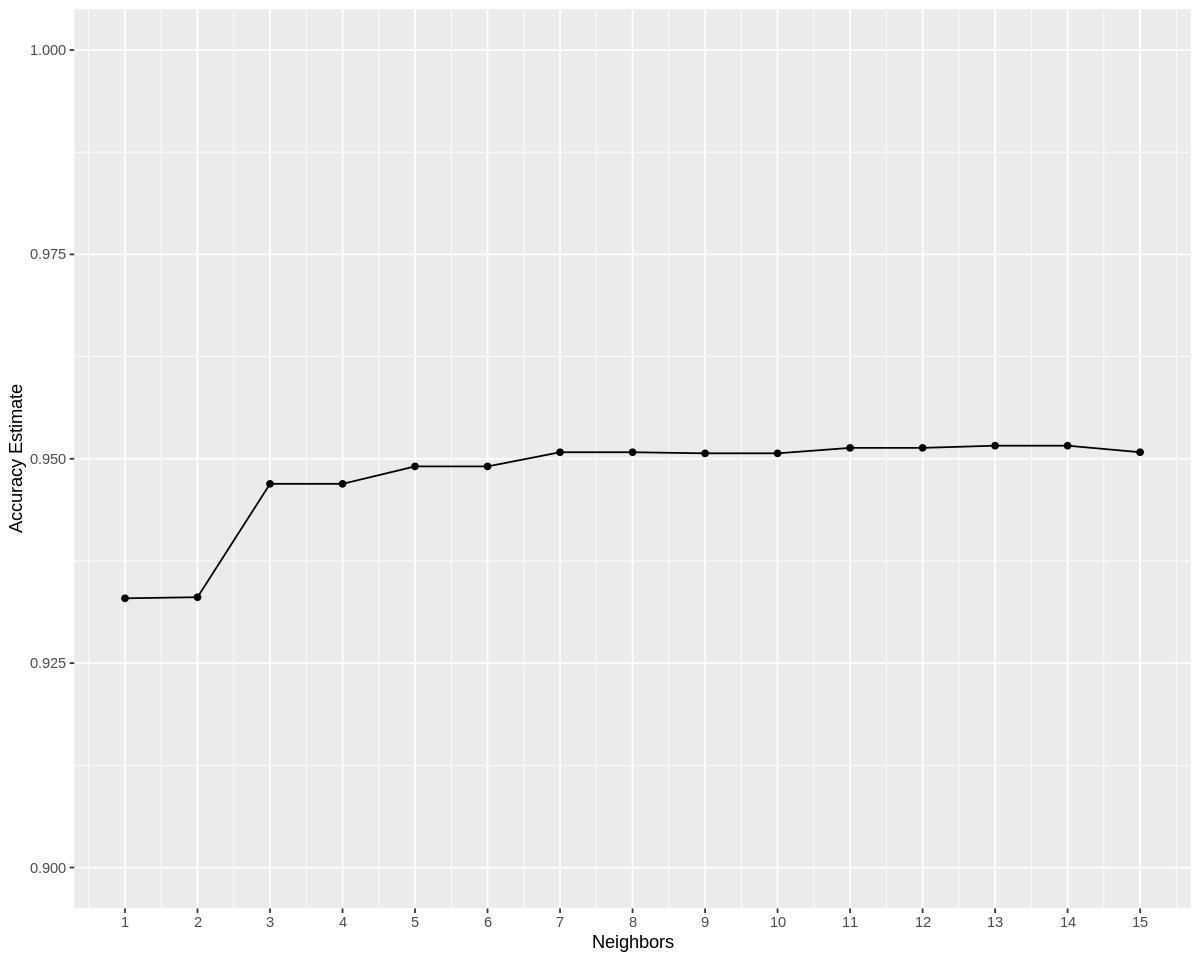

In [32]:
accuracy_versus_k <- ggplot(diabetes_accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        scale_x_continuous(breaks = seq(0, 25, by = 1)) +  
        scale_y_continuous(limits = c(0.9, 1.0))
accuracy_versus_k

## Visualization of results

# Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# References

Mohammed Mustafa. 2023. "Diabetes prediction dataset: A Comprehensive Dataset for Predicting Diabetes with Medical & Demographic Data", Version 1.